# Import packages

In [25]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 16-02-2022
# --- Last Modified: Thu 17 Feb 2022 00:34:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Evaluate Navigators with a pretrained attr discrim network.
"""
%matplotlib inline

import os

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F

import legacy

In [245]:
generator_pkl = 'ffhq512'
#navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00028-ffhq512-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_16-dys_T-vars_0.5-kimg160-batch32/network-snapshot-000160.pkl'
navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00032-ffhq512-z_18-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_16-dys_T-vars_0.5-kimg160-batch32/network-snapshot-000160.pkl'
attr_discrim_pkl = '/mnt/hpc_hdd_2/repo_results/stylegan2/results_vc2_byvae_ffhq512/00033-vc2_gan-ffhq-4gpu-config-c/converted_ps_sc/00000-convert/attr_discrim_model/00005-00012-pseudo_attr_data-attr-ch_3-dout_24-netn_resnet50-pretr_True-loss_reg-tsize_17000-kimg25000-batch64-noaug/network-snapshot-002016.pkl'

attr_names = ['azimuth',
                'haircolor',
                'smile',
                'gender',
                'main_fringe',
                'left_fringe',
                'age',
                'light_right',
                'light_left',
                'light_vertical',
                'hair_style',
                'clothes_color',
                'saturation',
                'ambient_color',
                'elevation',
                'neck',
                'right_shoulder',
                'left_shoulder',
                'background_1',
                'background_2',
                'background_3',
                'background_4',
                'right_object',
                'left_object']
used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17] # more accurate

seed = 2022
outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00028-ffhq512-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_16-dys_T-vars_0.5-kimg160-batch32/eval_nav'
n_samples_per = 100
var_scale_ls = [1, 1, 1, 1, 1, 1,
                1, 1, 1, 1, 1, 1,
                1, 1, 1, 1, 1, 1,
                1, 1, 1, 1, 1, 1]
batch_gpu = 4
truncation_psi = 0.5

In [246]:
print('Loading generator networks from "%s"...' % generator_pkl)

resume_specs = {
    'ffhq256':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
    'ffhq512':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
    'ffhq1024':    'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
    'celebahq256': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
    'lsundog256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
}

assert generator_pkl is not None
if generator_pkl in resume_specs:
    generator_pkl = resume_specs[generator_pkl] # predefined url

device = torch.device('cuda:0')
# device = torch.device('cpu')
with dnnlib.util.open_url(generator_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].requires_grad_(False).to(device) # type: ignore

with open(navigator_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    M = resume_data['M'].requires_grad_(False).to(device)

with open(attr_discrim_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    D = resume_data['D_ema'].requires_grad_(False).to(device)
print('Done loading.')

Loading generator networks from "ffhq512"...
Done loading.


In [16]:
print(D)

BackboneNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [247]:
os.makedirs(outdir, exist_ok=True)
print('seed:', seed)
rand_state = np.random.RandomState(seed)

seed: 2022


In [39]:
def show(img):
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tensor(-1.1843, device='cuda:0') tensor(1.2944, device='cuda:0')
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
tensor(1., device='cuda:0') tensor(0., device='cuda:0')


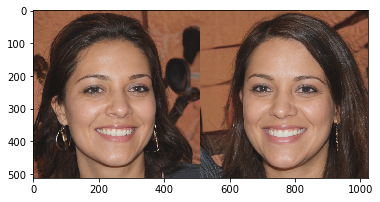

In [275]:
z = torch.from_numpy(rand_state.randn(1, G.z_dim)).to(device)
c = torch.from_numpy(rand_state.randn(1, G.c_dim)).to(device)
w = G.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)
dirs = M(w) # [b, nv_dim, num_ws, w_dim]
w_1 = w - dirs[:, 11] * 0.5
w_2 = w + dirs[:, 11] * 0.5 # [b, num_ws, w_dim]
image = G.synthesis(w_1, noise_mode='const')
image_2 = G.synthesis(w_2, noise_mode='const')
print(image.min(), image.max())

print(image.shape)
print(image_2.shape)
images = image
images_flat = images.view(1, -1)
img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
images = (images - img_min.view(1, 1, 1, 1)) / (img_max - img_min).view(1, 1, 1, 1)
print(images.max(), images.min())

show(torch.cat([image, image_2], dim=3)[0].cpu())

In [276]:
# Eval for each variation dim
# var_scale_ls = [5, 1, 1, 1, 5, 3, 1, 3, 5, 5]
attr_score_shift_summary_ls = []
img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
for i in range(M.nv_dim):
    attr_score_shift_ls = []
    print(f'Processing dim {i}')
    for j in range(0, n_samples_per, batch_gpu):
        b = batch_gpu if j+batch_gpu <= n_samples_per else n_samples_per-j

        z = torch.from_numpy(rand_state.randn(b, G.z_dim)).to(device)
        c = torch.from_numpy(rand_state.randn(b, G.c_dim)).to(device)
        w = G.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

        dirs = M(w) # [b, nv_dim, num_ws, w_dim]
        w_1 = w - dirs[:, i] * var_scale_ls[i] * 0.5
        w_2 = w + dirs[:, i] * var_scale_ls[i] * 0.5 # [b, num_ws, w_dim]

        images = torch.cat([G.synthesis(w_1, noise_mode='const'),
                            G.synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
        # Normalize to fit model D
        images_flat = images.view(2*b, -1)
        img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
        images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
        images = (images - img_mean) / img_std
        
        attr_pred = D(images) # [2b, nlabel]
        attr_score_shift = attr_pred[b:] - attr_pred[:b] # [b, nlabel]
        attr_score_shift_ls.append(attr_score_shift.to('cpu'))
    attr_score_shift_i = torch.cat(attr_score_shift_ls, dim=0).mean(0) # [nlabel]
    attr_score_shift_summary_ls.append(attr_score_shift_i)

Processing dim 0
Processing dim 1
Processing dim 2
Processing dim 3
Processing dim 4
Processing dim 5
Processing dim 6
Processing dim 7
Processing dim 8
Processing dim 9
Processing dim 10
Processing dim 11
Processing dim 12
Processing dim 13
Processing dim 14
Processing dim 15
Processing dim 16
Processing dim 17


In [277]:
attr_score_shift_summary = torch.stack(attr_score_shift_summary_ls, dim=0) # [nv_dim, nlabel]
print(attr_score_shift_summary)
print(attr_score_shift_summary.shape)

tensor([[ 6.3369e-03,  2.1035e-02,  8.1956e-03,  5.0928e-03, -4.4405e-03,
         -3.4830e-03, -4.2109e-03, -2.7256e-02,  2.2954e-02, -6.2319e-03,
         -1.1393e-03, -1.5226e-04, -5.0257e-02,  4.4458e-02,  1.2262e-02,
         -3.2768e-03,  8.5825e-03, -1.0489e-03,  6.3313e-03,  1.0108e-02,
         -3.5046e-04,  3.3605e-02, -3.9789e-02, -5.0958e-03],
        [-8.1709e-03,  2.1079e-02, -6.0151e-03,  1.5829e-02,  1.3275e-02,
         -3.4642e-03, -2.1793e-02,  1.0298e-02, -1.4373e-02,  1.4523e-03,
          3.2203e-03, -7.3051e-03,  1.4728e-02, -1.4094e-02,  1.6381e-02,
          2.0710e-02, -6.0631e-03,  2.4766e-03, -4.5455e-02,  8.9689e-03,
          3.4478e-03,  1.1943e-02,  7.6361e-03,  1.7767e-03],
        [-1.0610e-01,  1.1827e-03, -1.3605e-02,  3.0319e-02, -4.5747e-02,
         -5.9482e-02,  1.9887e-02, -2.1848e-02,  2.4232e-03, -8.8049e-04,
          2.9678e-02,  8.4297e-04,  7.2020e-03, -1.3568e-03, -3.8987e-03,
         -2.9446e-02,  1.0581e-01,  8.6109e-02, -1.1721e-03,  

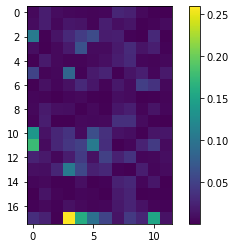

In [278]:
scores_np = np.abs(attr_score_shift_summary.numpy())
#plt.matshow(np.abs(attr_score_shift_summary.numpy()))
#plt.imshow(scores_np[[1,2,3,6], :16] / scores_np[[1,2,3,6], :16].max(axis=1, keepdims=True), cmap='viridis')
plt.imshow(scores_np[:, :12], cmap='viridis')
plt.colorbar()
plt.show()
    # plt.savefig(os.path.join(outdir, 'attr_score_shift.pdf'))